In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ppo import *
from dyn_model import *
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
tf.enable_eager_execution()

/home/norman/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plot = plt.plot

## Create environment.
You can select other Fetch environments such as FetchSlide-v1 and FetchPickAndPlace-v1.

In [4]:
import gym
import roboschool
env = gym.make("FetchPush-v1")
env = gym.wrappers.FlattenDictWrapper(env, dict_keys=['observation', 'desired_goal'])

## Initial exploration.
We let the robot explore randomly its environment for 20.000 steps, then build a predictive forward model out of this data.

In [5]:
states, actions, next_states = [], [], []

In [6]:
for ep in range(100):
    state = env.reset()
    for st in range(200):
        states.append(state)
        act = env.action_space.sample()
        next_state, _, _, _ = env.step(act)
        actions.append(act)
        next_states.append(next_state)
        state = next_state

In [7]:
len(states)

20000

In [8]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
obs_dim, act_dim

(28, 4)

## We create a normalizer.
The normalizer is useful to rescale all the input feature for the neural network, allowing it to work better.

In [9]:
normalizer = Normalizer(state_size = env.observation_space.shape[0], act_size = act_dim)
norm_dict = normalizer.fit(np.array(states), np.array(actions), np.array(next_states))

20000


In [10]:
norm_dict

{'state_mean': array([[ 1.29301575e+00,  7.49346642e-01,  5.18313559e-01,
          1.35582690e+00,  7.66256574e-01,  4.22655518e-01,
          6.28111504e-02,  1.69099313e-02, -9.56580409e-02,
         -1.03233692e-08,  9.35196948e-06,  1.13677021e-02,
         -3.23122699e-03,  2.43887046e-02,  4.70195855e-04,
          6.63676258e-06, -6.39846144e-04, -2.75495768e-05,
          2.60729829e-05,  2.58991721e-05, -4.44356191e-04,
          1.90899997e-05,  5.98204607e-04,  8.69875900e-04,
          9.14555155e-04,  1.36218147e+00,  7.50027806e-01,
          4.24699749e-01]]),
 'state_std': array([[1.45508285e-01, 1.74493398e-01, 1.04899953e-01, 1.04387114e-01,
         1.06606437e-01, 2.90179576e-02, 1.78686379e-01, 2.01689680e-01,
         1.08083489e-01, 1.55629043e-07, 1.31935764e-04, 1.60859032e-01,
         1.19755248e-01, 2.24962189e-01, 1.37958719e-02, 1.47448987e-02,
         1.45830626e-02, 1.49406111e-02, 1.39620818e-02, 1.43146530e-02,
         1.37961812e-02, 1.47552715e-02

In [11]:
state = states[np.random.randint(0, len(states))]
state_norm = (state - norm_dict["state_mean"])/norm_dict["state_std"]
state_norm

array([[ 9.09034138e-04, -3.39542316e-01, -9.84002644e-01,
         4.74850196e-01, -1.26811449e+00,  7.33673696e-02,
         2.76663336e-01, -3.76525342e-01,  9.74716892e-01,
         6.63331789e-02, -7.08827476e-02, -7.06687214e-02,
         2.69819238e-02, -1.08412461e-01,  2.17842725e-01,
         9.71503235e-01,  2.27658313e-01,  1.84393908e-03,
        -1.86741371e-03, -1.80927698e-03, -2.19710800e-01,
        -9.72563840e-01, -2.26388803e-01,  4.64925656e+00,
        -5.44515036e-01,  6.23862308e-01, -1.85074344e-02,
         1.10632500e-05]])

## Forward model.
Here we create our forward model, defining the hidden dimension and training specifications. Then we train it on the data we gathered.

In [12]:
dyn1 = NNDynamicsModel(state_size = env.observation_space.shape[0], act_size = act_dim, hid_size = 60, normalization = norm_dict, batch_size = 32, iterations = 5, learning_rate = 1e-3)

(32, 60)
(60, 60)
(60, 28)


states shape (20000, 28)
acts shape (20000, 4)
delta states shape (20000, 28)
states mean shape (1, 28) (1, 28)
acts mean shape (1, 4) (1, 4)
delta_states mean shape (1, 28) (1, 28)
train indices shape (18000,)
eval indices shape (2000,)


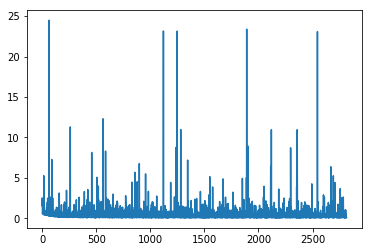

tf.Tensor(0.5639618, shape=(), dtype=float32)
tf.Tensor(0.054293625, shape=(), dtype=float32)
tf.Tensor(0.30986312, shape=(), dtype=float32)
tf.Tensor(0.08200187, shape=(), dtype=float32)
tf.Tensor(0.056545444, shape=(), dtype=float32)
tf.Tensor(0.060324583, shape=(), dtype=float32)
tf.Tensor(0.47442967, shape=(), dtype=float32)
tf.Tensor(0.059993166, shape=(), dtype=float32)
tf.Tensor(0.06089255, shape=(), dtype=float32)
tf.Tensor(0.07657839, shape=(), dtype=float32)
tf.Tensor(0.07748006, shape=(), dtype=float32)
tf.Tensor(0.064129055, shape=(), dtype=float32)
tf.Tensor(0.62317765, shape=(), dtype=float32)
tf.Tensor(0.07429095, shape=(), dtype=float32)
tf.Tensor(0.21965642, shape=(), dtype=float32)
tf.Tensor(0.32581648, shape=(), dtype=float32)
tf.Tensor(0.0686006, shape=(), dtype=float32)
tf.Tensor(0.06396227, shape=(), dtype=float32)
tf.Tensor(0.4445221, shape=(), dtype=float32)
tf.Tensor(0.18768556, shape=(), dtype=float32)
tf.Tensor(0.060289435, shape=(), dtype=float32)
tf.Tensor(

In [13]:
dyn1.fit({"states": np.array(states[:len(states)]), "acts": np.array(actions[:len(actions)]), "next_states" : np.array(next_states[:len(next_states)])}, plot = 1)

## PPO.
We initialize an actor and a critic, taken from the ppo.py file. The RL algorithm is indeed PPO, that has been showed to be effective in many continuous control scenarios.

In [14]:
act_opt = tf.train.AdamOptimizer(learning_rate=0.0001)
crt_opt = tf.train.AdamOptimizer(learning_rate=0.001)

state_dim = obs_dim
action_dim = act_dim

actor = Actor(state_dim, action_dim, 64, init_w= .01, bias = 0., use_bias = True)
critic = Critic(state_dim, action_dim, 64)
critic_target = Critic(state_dim, action_dim, 64)

actor(np.random.randn(1, state_dim)), critic(np.random.randn(1, state_dim))

((<tf.Tensor: id=493152, shape=(1, 4), dtype=float64, numpy=array([[-0.00580388,  0.00657968,  0.01338787,  0.01077531]])>,
  <tf.Tensor: id=493183, shape=(1, 4), dtype=float64, numpy=array([[0.7408162 , 0.76374063, 0.72933193, 0.74938222]])>),
 <tf.Tensor: id=493263, shape=(1, 1), dtype=float64, numpy=array([[0.16467211]])>)

In [15]:
states = []
actions = []
next_states = []
rewards = []
probs_acts = []
v_losses = []
a_losses= []
gamma = 0.99
noise_factor = 1.
r_list = []
ent_level = 0.01
stop = 1000



## Curiosity reward.
This is our intrinsitc reward, defined as the MSE between the expected next state and the real one.

In [16]:
def compute_intr_reward(state, act, next_state):
#    st_ft, next_st_ft = inv_dyn.extract_feats(state, next_state)
    pred_dyn = dyn1.predict(state, act, next_states = True)
    return tf.losses.mean_squared_error(np.expand_dims(next_state, axis = 0), pred_dyn).numpy()*1e2

In [17]:
compute_intr_reward(state, act, next_state)

20.08627951145172

In [18]:
done = False

In [19]:
new_states, new_actions, new_next_states = [], [], []

In [20]:
def evaluate_policy(show = False):
    global r_avg, r_norm
    rew_tot = 0
    for k in range(5):
        state = env.reset()
        ep_rew = 0
        for st in range(max_steps):
         #   print(state)
         #   state -= norm_dict["state_mean"][0]
            action = policy_net.get_action(np.float64(state))
         #   print("a", action)
          #  action+= np.random.randn(4)*0.2
            next_state, _, _, _ = env.step(action)
            if show: env.render()
         #   state -= norm_dict["state_mean"][0]
            reward = compute_intr_reward(state, action, next_state)
            reward = np.clip(reward, -1, 1)
            
            ep_rew += reward
            if done:
                break
            state = next_state
        rew_tot+=ep_rew
    
    return rew_tot/5

## Training phase.
Here is the main training loop. You can see plots of various losses, as well as the average reward, that should go up in time. You can see a render of the robot exploring and learning, too. Tip: in the MuJoCo render window, press F several times to make the simulation go faster, otherwise the training loop will be slowed down by the required frames per second. 

In [21]:
new_states, new_actions, new_next_states = [], [], []

Creating window glfw
ep rew avg 0.35408801563789893
ep reward =  0.35408801563789893
ep rew avg 0.39561518273956153
ep reward =  0.43714234984122413
ep rew avg 0.41402372944313964
ep reward =  0.4508408228502958
ep rew avg 0.38828555035905765
ep reward =  0.31107101310681173
ep rew avg 0.3880560338700434
ep reward =  0.38713796791398636
ep rew avg 0.5293673046168124
ep reward =  1.2359236583506572
ep rew avg 0.4997220659130822
ep reward =  0.3218506336907012
ep rew avg 0.48745516424233415
ep reward =  0.4015868525470978
ep rew avg 0.47544600279568133
ep reward =  0.37937271122245875
ep rew avg 0.458529665169749
ep reward =  0.3062826265363583
ep rew avg 0.44734958357563215
ep reward =  0.33554876763446373
ep rew avg 0.44261348372316434
ep reward =  0.39051638534601807
ep rew avg 0.43511739014853934
ep reward =  0.3451642672530397
ep rew avg 0.43267150949718924
ep reward =  0.40087506102963744
ep rew avg 0.4291157388051185
ep reward =  0.379334949116128
ep rew avg 0.43695914082313436
ep

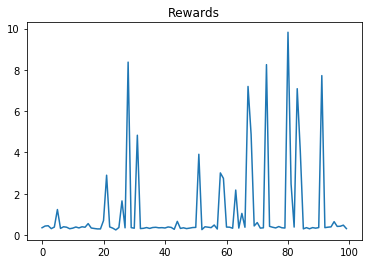

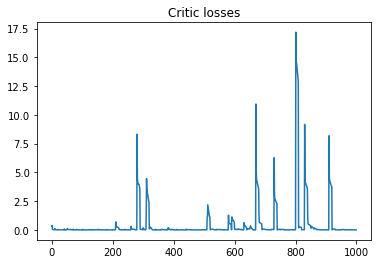

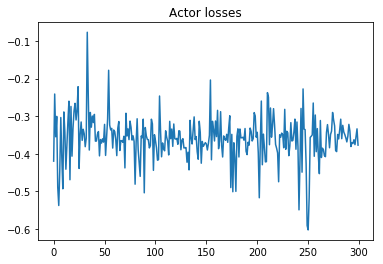

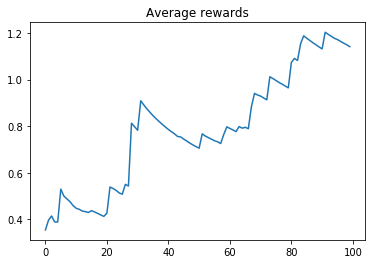

ep rew avg 1.133719394856385
ep reward =  0.33505143892398337
ep rew avg 1.125493317311074
ep reward =  0.2946594852346607
ep rew avg 1.148089642187038
ep reward =  3.4529147795353765
ep rew avg 1.1478925962115651
ep reward =  1.1275968607378672
ep rew avg 1.1599783576316662
ep reward =  2.416897545322172
ep rew avg 1.1521259665728871
ep reward =  0.32762490540108047
ep rew avg 1.144525925056986
ep reward =  0.3389215243714716
ep rew avg 1.1373365487843208
ep reward =  0.3680732876091497
ep rew avg 1.1300003478617406
ep reward =  0.3376906482230879
ep rew avg 1.1230630926080603
ep reward =  0.36690226995688136
ep rew avg 1.1164086597273541
ep reward =  0.3844210428496808
ep rew avg 1.1093314770188762
ep reward =  0.3237641963778515
ep rew avg 1.1026685281905961
ep reward =  0.35641825942320793
ep rew avg 1.096088230001582
ep reward =  0.3525145346429781
ep rew avg 1.0896937582206987
ep reward =  0.36072397520001687
ep rew avg 1.0879297957037857
ep reward =  0.8850741062587986
ep rew av

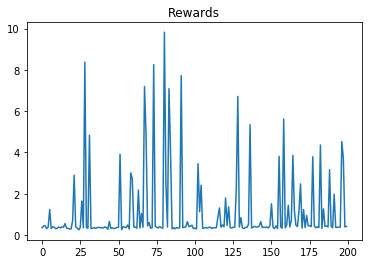

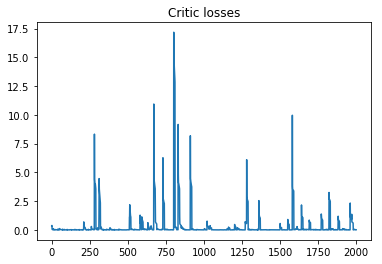

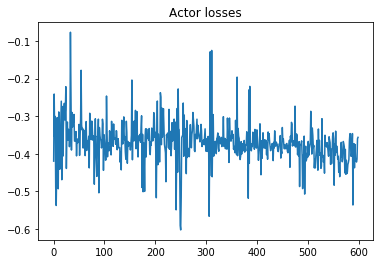

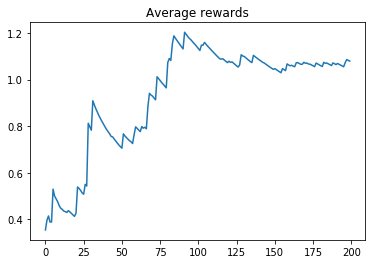

ep rew avg 1.0783988475516142
ep reward =  0.8550681613769484
ep rew avg 1.07478589764486
ep reward =  0.3485829663873119
ep rew avg 1.0710588296030603
ep reward =  0.31819108515946937
ep rew avg 1.0676992969092383
ep reward =  0.385714160063344
ep rew avg 1.064938870411794
ep reward =  0.5018118649331882
ep rew avg 1.0924407958100402
ep reward =  6.730335502450544
ep rew avg 1.0892257138287285
ep reward =  0.4269188256785128
ep rew avg 1.0860113556877757
ep reward =  0.4206392205105658
ep rew avg 1.082792614554794
ep reward =  0.4132944588945975
ep rew avg 1.084266820211751
ep reward =  1.392375802515744
ep rew avg 1.0807326531548513
ep reward =  0.3385575712059108
ep rew avg 1.0772850662777582
ep reward =  0.3498442352110942
ep rew avg 1.0740437121318822
ep reward =  0.38687663320615684
ep rew avg 1.0717616363512534
ep reward =  0.5856794950773292
ep rew avg 1.0689023503595743
ep reward =  0.4570151481402718
ep rew avg 1.0653879127729722
ep reward =  0.3097838316534762
ep rew avg 1.0

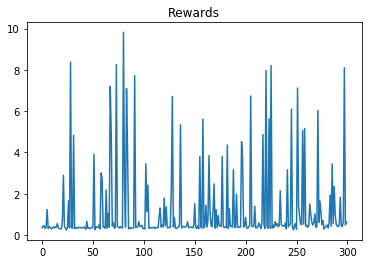

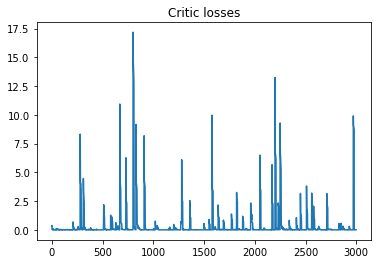

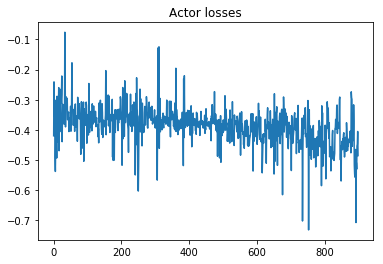

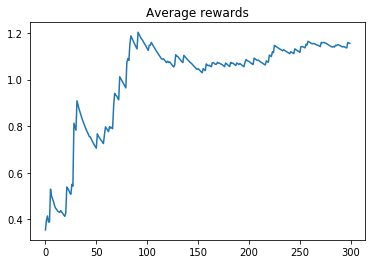

ep rew avg 1.152876072221478
ep reward =  0.3168831239008796
ep rew avg 1.1509028404893702
ep reward =  0.5569600891249138
ep rew avg 1.1485852105928378
ep reward =  0.4486609818400211
ep rew avg 1.1679601201143153
ep reward =  7.0385577051220025
ep rew avg 1.1657790758461455
ep reward =  0.5027416183224886
ep rew avg 1.1969888461764038
ep reward =  10.715968796905145
ep rew avg 1.1946623380048198
ep reward =  0.48275083750013437
ep rew avg 1.191844778666703
ep reward =  0.32685406186487853
ep rew avg 1.1902151582733493
ep reward =  0.6882920771204226
ep rew avg 1.187731660287949
ep reward =  0.42033078279928304
ep rew avg 1.1870391505277864
ep reward =  0.9723611248773523
ep rew avg 1.184653837878722
ep reward =  0.44282160401962756
ep rew avg 1.1827126607727039
ep reward =  0.5770654036950873
ep rew avg 1.181087345229702
ep reward =  0.6723635802700301
ep rew avg 1.1785998107555655
ep reward =  0.3975139858766852
ep rew avg 1.1768005317728054
ep reward =  0.610027652203371
ep rew avg

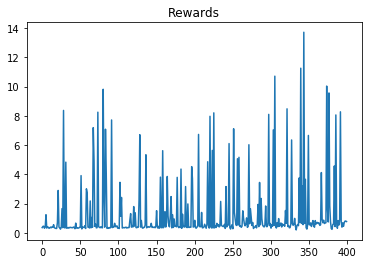

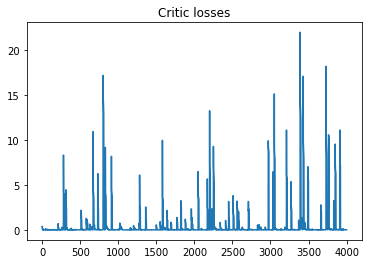

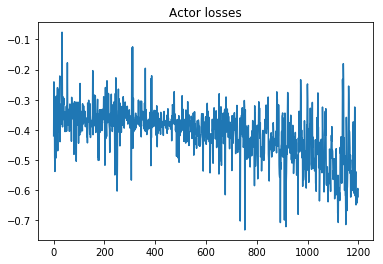

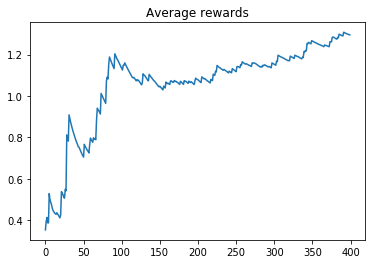

ep rew avg 1.2937159395155333
ep reward =  0.8334779904771494
ep rew avg 1.2965026271074531
ep reward =  2.413964351467257
ep rew avg 1.2957394383051917
ep reward =  0.9889375397960976
ep rew avg 1.2944508101522685
ep reward =  0.7751336645242191
ep rew avg 1.2936819798357209
ep reward =  0.9830745319504786
ep rew avg 1.2983819853684149
ep reward =  3.2018842261095415
ep rew avg 1.29694732116707
ep reward =  0.7144736554209885
ep rew avg 1.2956405967994598
ep reward =  0.7638037791821262
ep rew avg 1.2941391018340902
ep reward =  0.6815291559632897
ep rew avg 1.2927466066837197
ep reward =  0.7232160901821771
ep rew avg 1.291545896022932
ep reward =  0.7992545250999683
ep rew avg 1.2905810438430565
ep reward =  0.8940267979141936
ep rew avg 1.3035311623922101
ep reward =  6.638980004643599
ep rew avg 1.3016994004851838
ep reward =  0.5451817328832931
ep rew avg 1.302187280318449
ep reward =  1.5041695312902448
ep rew avg 1.3019124526798627
ep reward =  1.187858982666512
ep rew avg 1.30

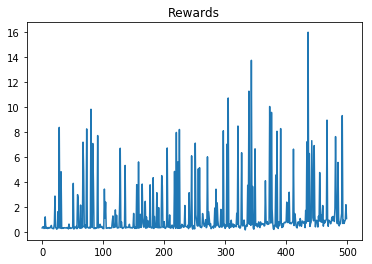

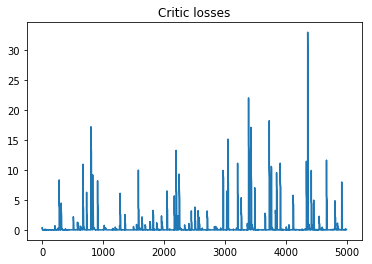

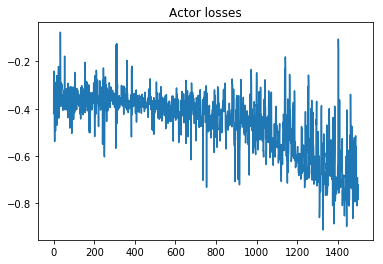

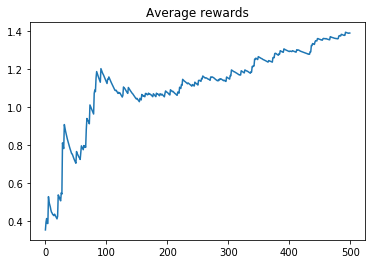

ep rew avg 1.3903183596017736
ep reward =  0.9899687203869689
ep rew avg 1.3890936879318672
ep reward =  0.7755331813086741
ep rew avg 1.3989691274489533
ep reward =  6.356439765026153
ep rew avg 1.398071720967256
ep reward =  0.9466762606734846
ep rew avg 1.3975872028852023
ep reward =  1.1533900895301485
ep rew avg 1.3967288900364105
ep reward =  0.9632809013965016
ep rew avg 1.3958407039614456
ep reward =  0.9464185500291933
ep rew avg 1.4017018080348036
ep reward =  4.373281573227359
ep rew avg 1.401271431663136
ep reward =  1.1826402348560805
ep rew avg 1.4006513162584568
ep reward =  1.085012575276778
ep rew avg 1.39969074268631
ep reward =  0.9097982208913891
ep rew avg 1.398797305660217
ep reward =  0.9422509853266092
ep rew avg 1.398223041937891
ep reward =  1.1042000161069154
ep rew avg 1.3973805014378002
ep reward =  0.9651572248912998
ep rew avg 1.396980754899781
ep reward =  1.1915110343579727
ep rew avg 1.3984441253569029
ep reward =  2.1520799107747735
ep rew avg 1.40371

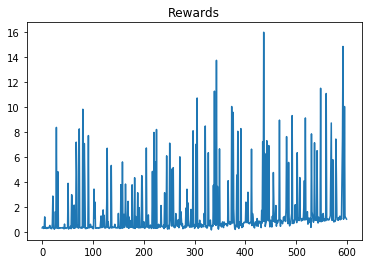

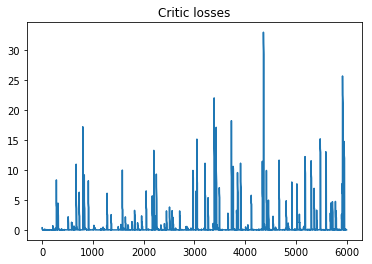

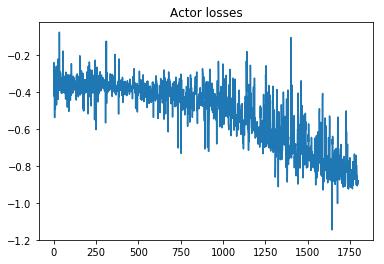

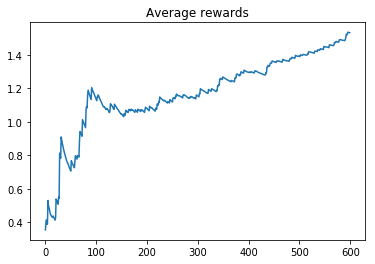

ep rew avg 1.543133625466739
ep reward =  8.541874806775013
ep rew avg 1.5428509060959594
ep reward =  1.372936564257543
ep rew avg 1.5434722008246569
ep reward =  1.9174916275005671
ep rew avg 1.5422954047561415
ep reward =  0.83268737544131
ep rew avg 1.541502533209272
ep reward =  1.0626081189002434
ep rew avg 1.5411607414410406
ep reward =  1.3343767216611013
ep rew avg 1.5402632408386654
ep reward =  0.9963778757992259
ep rew avg 1.5429222545314791
ep reward =  3.156943566069458
ep rew avg 1.5421934060117306
ep reward =  1.0990535060045659
ep rew avg 1.5446409135648362
ep reward =  3.0351730134061654
ep rew avg 1.543517078336004
ep reward =  0.8579775887483265
ep rew avg 1.5422852864622092
ep reward =  0.7896604515735817
ep rew avg 1.5415324011617173
ep reward =  1.0807665972606628
ep rew avg 1.548241710772498
ep reward =  5.661048502181075
ep rew avg 1.547324290000971
ep reward =  0.9840279362833826
ep rew avg 1.5460100349998873
ep reward =  0.7377432093335301
ep rew avg 1.581472

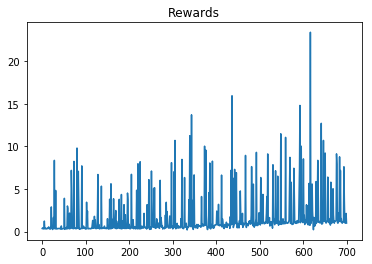

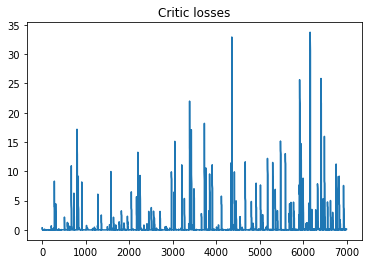

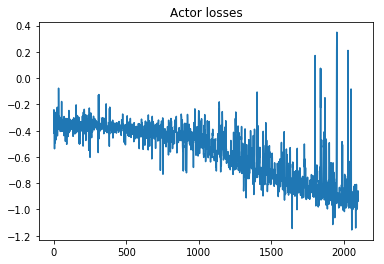

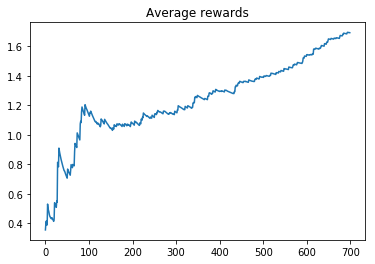

ep rew avg 1.7100859899662644
ep reward =  14.078661686842679
ep rew avg 1.7091467588943778
ep reward =  1.0507457775020157
ep rew avg 1.7083850156503688
ep reward =  1.1736412583559286
ep rew avg 1.7075439000842898
ep reward =  1.1162396571307909
ep rew avg 1.7066283434565124
ep reward =  1.0620764775012503
ep rew avg 1.7054616765004935
ep reward =  0.8829614725073043
ep rew avg 1.704997728602872
ep reward =  1.3774505128822057
ep rew avg 1.7043871012515053
ep reward =  1.2726735638352693
ep rew avg 1.7034090240225335
ep reward =  1.0109303459103103
ep rew avg 1.7024358078618325
ep reward =  1.0124255499249557
ep rew avg 1.7025418332227593
ep reward =  1.7778198394807987
ep rew avg 1.7012678578725409
ep reward =  0.7954713838671523
ep rew avg 1.7006916220672825
ep reward =  1.290411728723484
ep rew avg 1.7008617508048518
ep reward =  1.8221635406916903
ep rew avg 1.7002761732422094
ep reward =  1.2821737935155397
ep rew avg 1.69929486109098
ep reward =  0.9976566729619663
ep rew avg 1

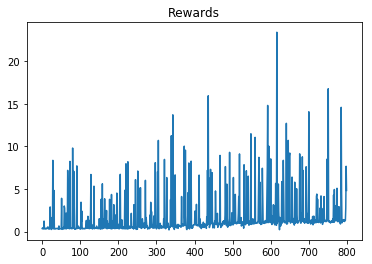

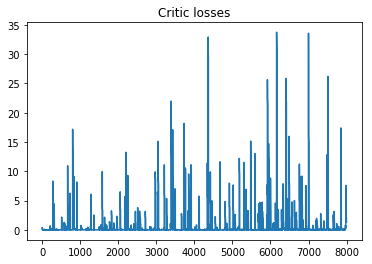

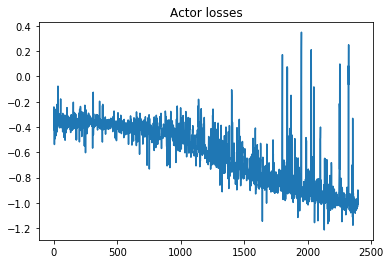

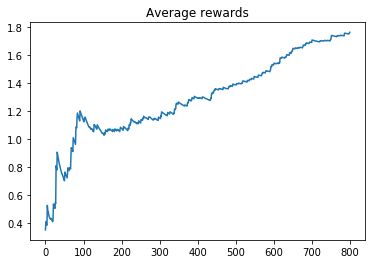

ep rew avg 1.788331781667148
ep reward =  20.302959610911785
ep rew avg 1.787599174132154
ep reward =  1.2007805386019754
ep rew avg 1.786649374843803
ep reward =  1.0249103455862496
ep rew avg 1.7860676046511261
ep reward =  1.3189061399316415
ep rew avg 1.785937652534315
ep reward =  1.6814561506180326
ep rew avg 1.7986090288711605
ep reward =  11.999066980031785
ep rew avg 1.7977929396727927
ep reward =  1.1400250457882066
ep rew avg 1.7974030573772117
ep reward =  1.4827680448433966
ep rew avg 1.7967370404837575
ep reward =  1.2585953905727365
ep rew avg 1.8144205797213766
ep reward =  16.120403822955268
ep rew avg 1.8138831151173889
ep reward =  1.3785367858872632
ep rew avg 1.8130218501437823
ep reward =  1.1145359565489343
ep rew avg 1.812488081970582
ep reward =  1.3790683253319003
ep rew avg 1.8117031387379123
ep reward =  1.1735442905774107
ep rew avg 1.8109552883612896
ep reward =  1.2022050817904528
ep rew avg 1.810598485903511
ep reward =  1.5198044828139246
ep rew avg 1.8

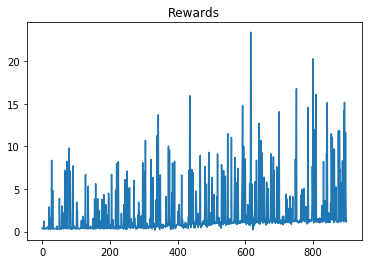

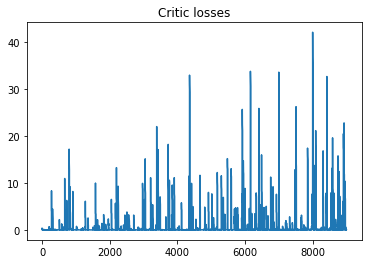

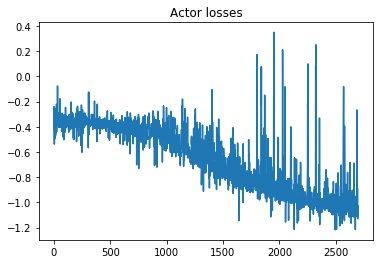

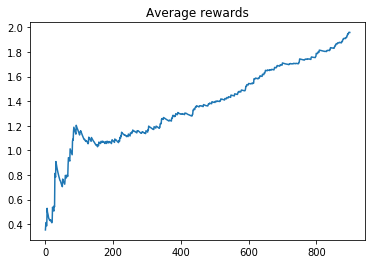

ep rew avg 1.9610300799319635
ep reward =  4.594433122203554
ep rew avg 1.9603167794706298
ep reward =  1.3176330638088984
ep rew avg 1.959660260524606
ep reward =  1.367480171211355
ep rew avg 1.959558132827965
ep reward =  1.86733682276099
ep rew avg 1.9587659288253663
ep reward =  1.242613510476076
ep rew avg 1.95813995236123
ep reward =  1.391631252317893
ep rew avg 1.9573929452513494
ep reward =  1.2806045036995783
ep rew avg 1.958532961154311
ep reward =  2.99252738514042
ep rew avg 1.9590845833988204
ep reward =  2.4599575814136188
ep rew avg 1.9583544926969005
ep reward =  1.2947020446517854
ep rew avg 1.957402510641817
ep reward =  1.0910988405157696
ep rew avg 1.9566605115535793
ep reward =  1.2806993421691004
ep rew avg 1.9557443355531443
ep reward =  1.1201918231563468
ep rew avg 1.9549322494508288
ep reward =  1.2134976380366425
ep rew avg 1.9541716214921205
ep reward =  1.2589576672326075
ep rew avg 1.9537282967499991
ep reward =  1.5480861577088945
ep rew avg 1.956386451

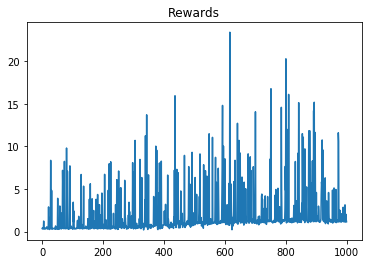

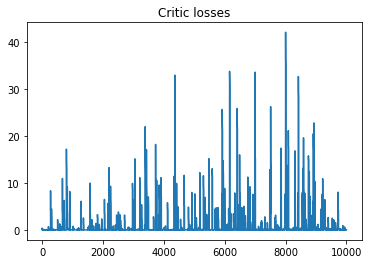

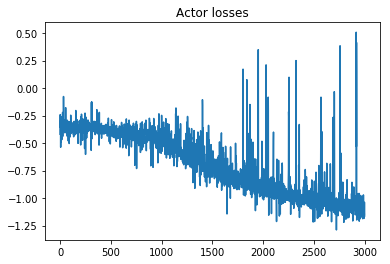

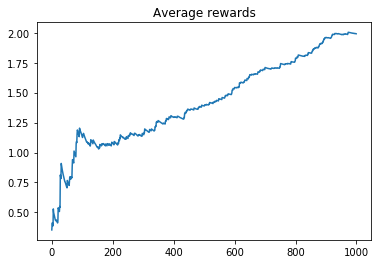

ep rew avg 1.99079302375665
ep reward =  1.2247694094185135
ep rew avg 1.9898299576515683
ep reward =  1.0258007864649699
ep rew avg 1.9890804291575241
ep reward =  1.2380528781250177
ep rew avg 1.9884358656576167
ep reward =  1.341938675250276
ep rew avg 1.9876566017823896
ep reward =  1.205275671054551
ep rew avg 1.986802909637862
ep reward =  1.1288423043879448
ep rew avg 1.9858145144634207
ep reward =  0.9914889689753181
ep rew avg 1.985155688321045
ep reward =  1.3217177629485377
ep rew avg 1.984337183561013
ep reward =  1.1592843854487
ep rew avg 1.9868168488804423
ep reward =  4.488799156184541
ep rew avg 1.9862048461838686
ep reward =  1.3680821226444095
ep rew avg 1.9854233474136889
ep reward =  1.1953280907619046
ep rew avg 1.9846065613481683
ep reward =  1.158019063041138
ep rew avg 1.9884463465902966
ep reward =  5.878148796866299
ep rew avg 1.9874832844728183
ep reward =  1.0109382973496395
ep rew avg 1.9893973766442523
ep reward =  3.932200930649742
ep rew avg 1.988698744

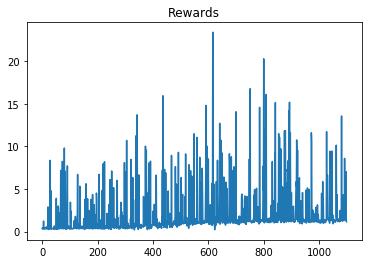

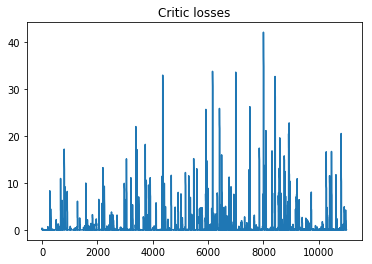

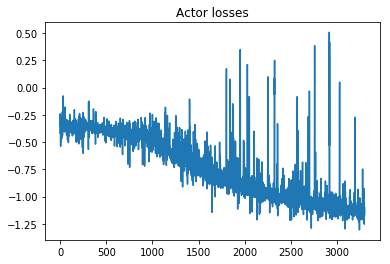

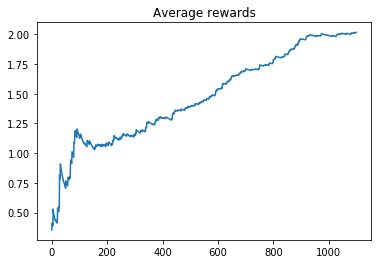

ep rew avg 2.022297417064809
ep reward =  8.785993606266857
ep rew avg 2.0216084050367256
ep reward =  1.2630061621166533
ep rew avg 2.026172589262658
ep reward =  7.055903606240463
ep rew avg 2.025829399172612
ep reward =  1.6472907298521022
ep rew avg 2.0250405476267885
ep reward =  1.1541484410372504
ep rew avg 2.024158353496846
ep reward =  1.0493338399101049
ep rew avg 2.023497109695353
ep reward =  1.2921614652441349
ep rew avg 2.0226758236134126
ep reward =  1.113512130905292
ep rew avg 2.022491042594091
ep reward =  1.817753673185507
ep rew avg 2.021849227396188
ep reward =  1.3100761729219812
ep rew avg 2.0213655185777544
ep reward =  1.484448730116128
ep rew avg 2.0208483290584374
ep reward =  1.4462507730968355
ep rew avg 2.022387096326266
ep reward =  3.7334962981512945
ep rew avg 2.021742354956377
ep reward =  1.3041452102697804
ep rew avg 2.0273140322996905
ep reward =  8.23416259275109
ep rew avg 2.0264031181603213
ep reward =  1.0107338527632237
ep rew avg 2.02554484447

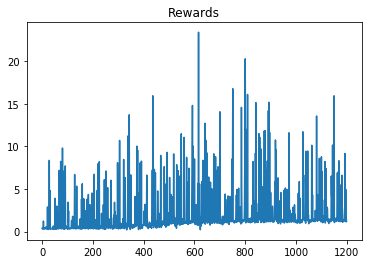

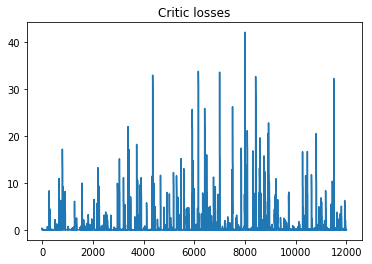

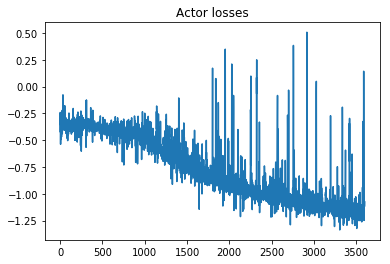

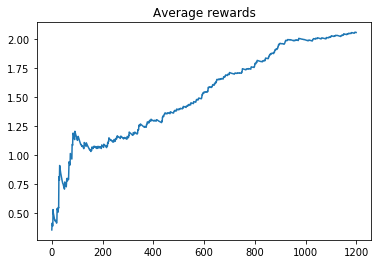

ep rew avg 2.0546042669376425
ep reward =  1.4725226945301984
ep rew avg 2.058025737745405
ep reward =  6.16721217786835
ep rew avg 2.0572694444967006
ep reward =  1.1482049595542776
ep rew avg 2.056526505267483
ep reward =  1.1627706125182158
ep rew avg 2.0576667716441803
ep reward =  3.4305474891880294
ep rew avg 2.0571950059808377
ep reward =  1.4887173816532595
ep rew avg 2.0574963591681246
ep reward =  2.4209283030359074
ep rew avg 2.0570468025079776
ep reward =  1.5144319137107232
ep rew avg 2.056455458316764
ep reward =  1.3421116753306706
ep rew avg 2.055812349481017
ep reward =  1.2782937670635874
ep rew avg 2.0552375177253936
ep reward =  1.3596910934211337
ep rew avg 2.054579032950403
ep reward =  1.2571539704367751
ep rew avg 2.053974719739172
ep reward =  1.3215471077273833
ep rew avg 2.053387539878467
ep reward =  1.3411383688435308
ep rew avg 2.0559733287094937
ep reward =  5.195120969576237
ep rew avg 2.057552708940816
ep reward =  3.9764996899975813
ep rew avg 2.056992

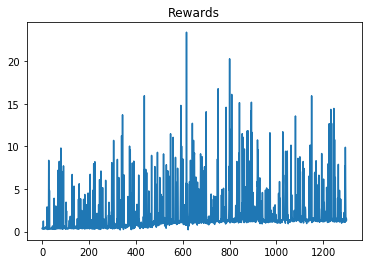

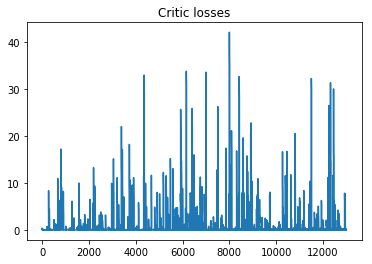

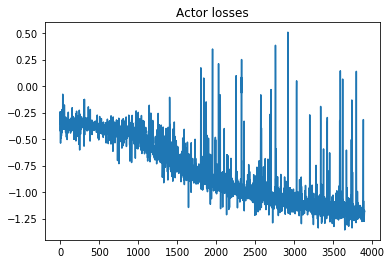

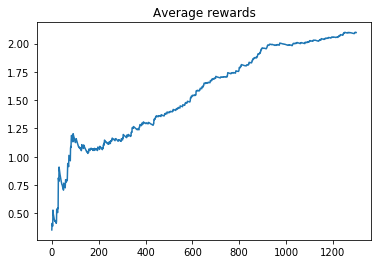

ep rew avg 2.096921086949195
ep reward =  1.1308102996736125
ep rew avg 2.1058051169098966
ep reward =  13.663928095782467
ep rew avg 2.1073149392998243
ep reward =  4.07310369098559
ep rew avg 2.1068616406342633
ep reward =  1.5162134794081794
ep rew avg 2.1061042697973904
ep reward =  1.1184926985151833
ep rew avg 2.10538129878265
ep reward =  1.1619041245467088
ep rew avg 2.1049639820955828
ep reward =  1.5599483887854149
ep rew avg 2.1042726249493526
ep reward =  1.2006688348265016
ep rew avg 2.1035742953644165
ep reward =  1.1901591982677928
ep rew avg 2.1034925973349945
ep reward =  1.9965498768215184
ep rew avg 2.102816467093788
ep reward =  1.2170858511126426
ep rew avg 2.102146903093924
ep reward =  1.2243484992723097
ep rew avg 2.1044193079604736
ep reward =  5.085814492873396
ep rew avg 2.1038353722026786
ep reward =  1.3371277222177014
ep rew avg 2.1032932928853354
ep reward =  1.391001069896447
ep rew avg 2.107634996468315
ep reward =  7.81697520808666
ep rew avg 2.1130656

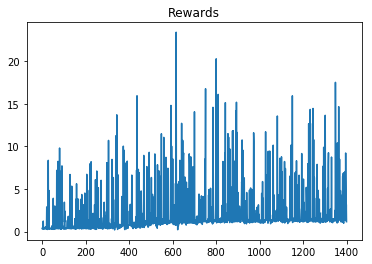

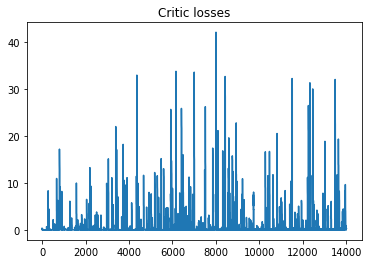

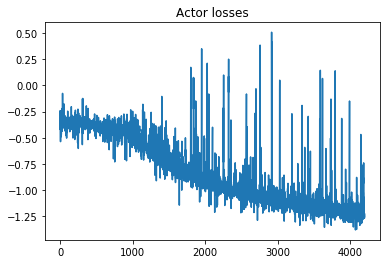

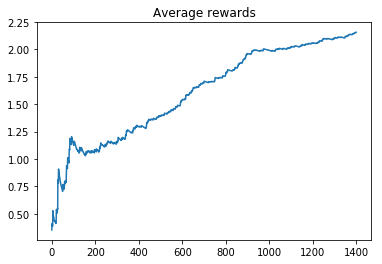

ep rew avg 2.154287770744186
ep reward =  1.3798293378386006
ep rew avg 2.1595998971477273
ep reward =  9.601888988509018
ep rew avg 2.162249780390944
ep reward =  5.877386087380728
ep rew avg 2.1663196836387084
ep reward =  7.876393940252456
ep rew avg 2.167015857605489
ep reward =  3.1444441069652385
ep rew avg 2.166440161800166
ep reward =  1.3575875553215155
ep rew avg 2.1657363321470093
ep reward =  1.176151839808881
ep rew avg 2.1653243625364915
ep reward =  1.585683120538306
ep rew avg 2.1646037299774594
ep reward =  1.149953086860478
ep rew avg 2.1639943438255647
ep reward =  1.3053692558059993
ep rew avg 2.163395928078767
ep reward =  1.3196297250942735
ep rew avg 2.1717978752068303
ep reward =  14.026945272904413
ep rew avg 2.177032682634323
ep reward =  9.568580770253902
ep rew avg 2.1764076263527725
ep reward =  1.2932031005220779
ep rew avg 2.1800886099393897
ep reward =  7.38499940141628
ep rew avg 2.1835270481552675
ep reward =  7.048917123622232
ep rew avg 2.18293331997

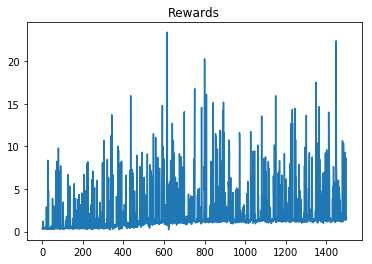

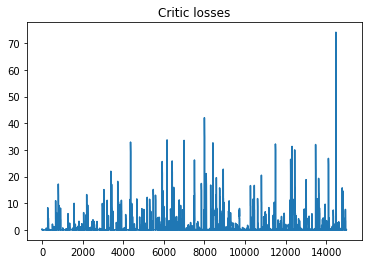

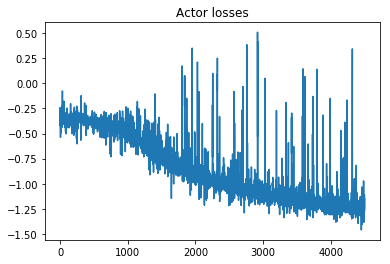

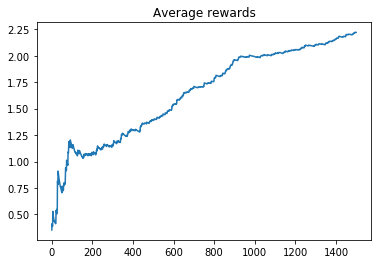

ep rew avg 2.2189450643067796
ep reward =  1.6134373146087455
ep rew avg 2.2226998351706277
ep reward =  7.858610901806969
ep rew avg 2.222038697324193
ep reward =  1.2290096519791405
ep rew avg 2.2215623570693412
ep reward =  1.5056229540277855
ep rew avg 2.220914546096209
ep reward =  1.246606842505571
ep rew avg 2.220987199672296
ep reward =  2.3303308316826588
ep rew avg 2.220541524700236
ep reward =  1.5493550167775538
ep rew avg 2.220515060378303
ep reward =  2.180633327225223
ep rew avg 2.2199686935810483
ep reward =  1.39604756332119
ep rew avg 2.2244835916452326
ep reward =  9.037464770499355
ep rew avg 2.223917307906099
ep reward =  1.3688288618141087
ep rew avg 2.2260142986072076
ep reward =  5.394567247982195
ep rew avg 2.2290083723068412
ep reward =  6.756047806153219
ep rew avg 2.2304288428611785
ep reward =  4.379600791573466
ep rew avg 2.2302562839244637
ep reward =  1.9690020537382225
ep rew avg 2.2295659719616756
ep reward =  1.1837433483378845
ep rew avg 2.2290394680

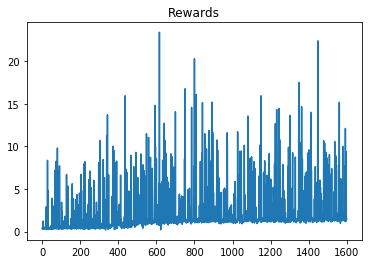

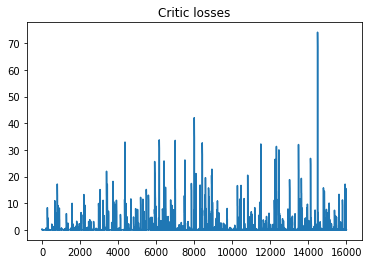

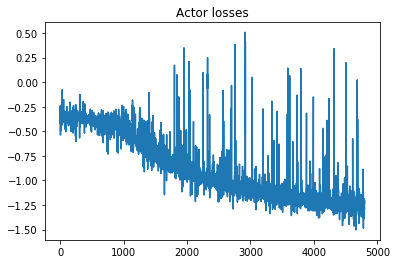

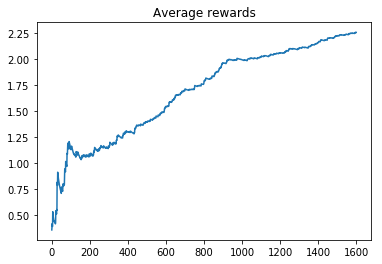

ep rew avg 2.2537379641362447
ep reward =  1.4958202220441308
ep rew avg 2.2532709420794688
ep reward =  1.5055686291816528
ep rew avg 2.2526821841352804
ep reward =  1.3094919575451058
ep rew avg 2.25216895344966
ep reward =  1.429460164399643
ep rew avg 2.2514402679983103
ep reward =  1.0826288040334475
ep rew avg 2.2520700902876
ep reward =  3.2629348645969003
ep rew avg 2.2515057241312437
ep reward =  1.3451336770231137
ep rew avg 2.251136809265987
ep reward =  1.6582906207986525
ep rew avg 2.250794311585742
ep reward =  1.7000580417516176
ep rew avg 2.250296325008979
ep reward =  1.4490359229966998
ep rew avg 2.2497206080254064
ep reward =  1.3228162644736585
ep rew avg 2.2491037732634767
ep reward =  1.255382971794461
ep rew avg 2.248514528687367
ep reward =  1.298652271998435
ep rew avg 2.2481145220119787
ep reward =  1.6029037546104519
ep rew avg 2.2477126932074767
ep reward =  1.5991610027413117
ep rew avg 2.247264664557525
ep reward =  1.5236983948852867
ep rew avg 2.24649487

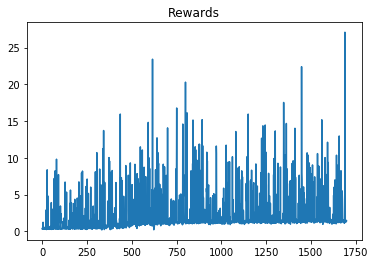

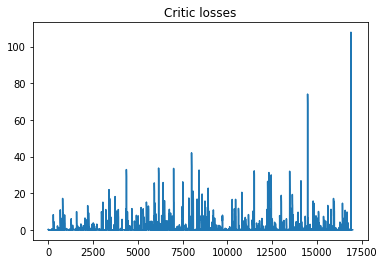

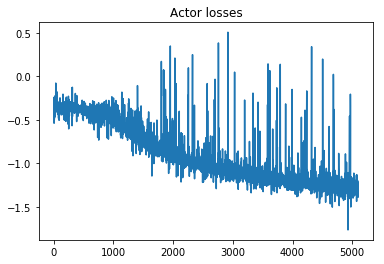

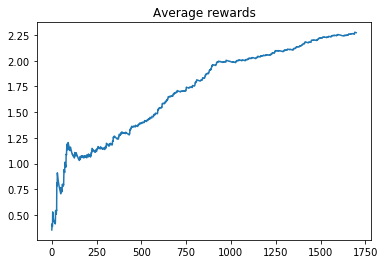

KeyboardInterrupt: 

In [22]:
#salva un intero episodio che ha una reward molto alta per fare episode replay
r_avg = 0.
PRINT = False
rand_w = .8
ep_rew_avg = 0
ev_rews = []
ep_rew_mean = 0
max_eps = 10000
max_steps = 100
ep_numb = 0
ep_avgs_list = []
while ep_numb < max_eps:
    states = []
    actions = []
    next_states = []
    rewards = []
    probs_acts = []
    ep_numb+=1
    state = env.reset()
    episode_reward = 0
    state = (state - norm_dict["state_mean"])/(norm_dict["state_std"])
    ep_buffer = []
    for step in range(max_steps):
        
        mu, sigma = actor(state.reshape((1,-1)))
        dist = tf.distributions.Normal(mu, sigma)
        action = np.array(dist.sample().numpy(), dtype = np.float64)
        act_clip = np.clip(action, -1, 1)
        act_prob = dist.log_prob(action)
        act_prob = np.exp(act_prob).reshape((1,-1))
        next_state, reward, done, _ = env.step(action[0])
        done = False
        state_nat = state*norm_dict["state_std"] + norm_dict["state_mean"]
        reward = compute_intr_reward(state_nat, act_clip, next_state)
        reward = np.clip(reward, -1, 1)
        if step == max_steps-1 : 
            done = True
        next_state = np.array(next_state, dtype = np.float64)
        next_state = (next_state - norm_dict["state_mean"])/(norm_dict["state_std"])
        env.render()
        episode_reward+=reward
        
        states.append(state.reshape((1,-1)))
        actions.append(action.reshape((1,-1)))
        next_states.append(next_state.reshape((1,-1)))
        rewards.append(np.array(reward).reshape((1,-1)))
        probs_acts.append(act_prob)
        
        new_states.append((state*(norm_dict["state_std"])) + norm_dict["state_mean"])
        new_actions.append((action*(norm_dict["act_std"])) + norm_dict["act_mean"])
        new_next_states.append((next_state*(norm_dict["state_std"])) + norm_dict["state_mean"])
        
        ep_buffer.append((state.reshape((1,-1)), action.reshape((1,-1))))
        
        if step % 49 == 0 and not step == 0:
            v_loss = critic_update(states, actions, next_states,
                        rewards, next_state, done, critic, critic_target, gamma, crt_opt)
            v_losses.append(v_loss.numpy())
            a = actor_update(2, 8, states, actions, probs_acts, rewards,
                    next_states, actor, critic, critic_target, gamma, ent_level, act_opt)
            a_losses.append(a)
        

        if done:                
            ep_rew_avg = (ep_rew_avg*(ep_numb-1))/(ep_numb)  + episode_reward/(ep_numb)
            ep_avgs_list.append(ep_rew_avg)
            print("ep rew avg", ep_rew_avg)
            print("ep reward = ", episode_reward)
            
            for k in range(8):
                v_loss = critic_update(states, actions, next_states,
                        rewards, next_state, done, critic, critic_target, gamma, crt_opt)
                v_losses.append(v_loss.numpy())
            a, grads = actor_update(4, 8, states, actions, probs_acts, rewards,
                    next_states, actor, critic, critic_target, gamma, ent_level, act_opt, want_grads = True)
            a_losses.append(a)
            r_list.append(episode_reward)   
            if ep_numb % 100 == 0 and not ep_numb == 0:
                plt.plot(r_list)
                plt.title("Rewards")
                plt.show()
                plt.plot(v_losses)
                plt.title("Critic losses")
                plt.show()
                plt.plot(a_losses)
                plt.title("Actor losses")
                plt.show()
                plt.plot(ep_avgs_list)
                plt.title("Average rewards")
                plt.show()
            break

        state = next_state
        
       